# Demostration of quadratically regularized OT


First we import the necessarily libraries, and define some ancillary functions.

In [1]:
from npdrot import drot, quaddrot
from sklearn.datasets import make_blobs

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dist_matrix(X1, X2, as_fortran=False):
    c1 = np.linalg.norm(X1, axis=1) ** 2
    c2 = np.linalg.norm(X2, axis=1) ** 2

    C = - X1 @ X2.T 
    C += c1.reshape(-1, 1) / 2
    C += c2.reshape(1, -1) / 2
        
    if as_fortran:
        return np.asfortranarray(C, dtype=np.float64)
    else:
        return C

## Simulation of data set

We will use two multimodal random datasets in 2d.

In [50]:
n_dim = 2
n_instances = 400
n_centers = 3
seed1, seed2 = 2493078133, 364262611

Xs, _ = make_blobs(n_instances, n_dim, centers=n_centers, random_state=seed1)
Xt, _ = make_blobs(n_instances, n_dim, centers=n_centers, random_state=seed2)

# Equal weight of each sample
p = np.ones(n_instances) / n_instances
q = np.ones(n_instances) / n_instances

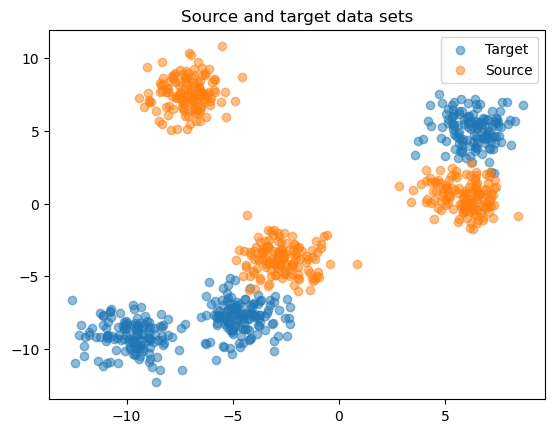

In [51]:
_, ax = plt.subplots(1, sharex=True, sharey=True)
ax.scatter(Xt[:,0], Xt[:,1], alpha=0.5, cmap='tab10', label='Target')
ax.scatter(Xs[:,0], Xs[:,1], alpha=0.5,cmap='tab10', label='Source')
ax.set_title("Source and target data sets")
_ = ax.legend()

## Computing transportation plans

In order to use OT for domain adaptation, we need the pairwise distances of the pointclouds. The resulting cost matrices are then normalized.

In [27]:
Cft = dist_matrix(Xs, Xt, as_fortran=True)

Cft /=Cft.max()

In [28]:
reg=10.

Quadratic regularization has the potential to speedup computations, which we illustrate below:

In [29]:
%timeit drot(np.outer(p, q), Cft, p, q, numba=True,  max_iters=5000, compute_r_primal=True, compute_r_dual=False, eps_abs=1e-4)

530 ms ± 135 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit quaddrot(np.outer(p, q), Cft, p, q,reg, numba=True,  max_iters=5000, compute_r_primal=True, compute_r_dual=False, eps_abs=1e-4)

176 ms ± 30.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Quadratic regularization impacts the sparsity of the solution, however

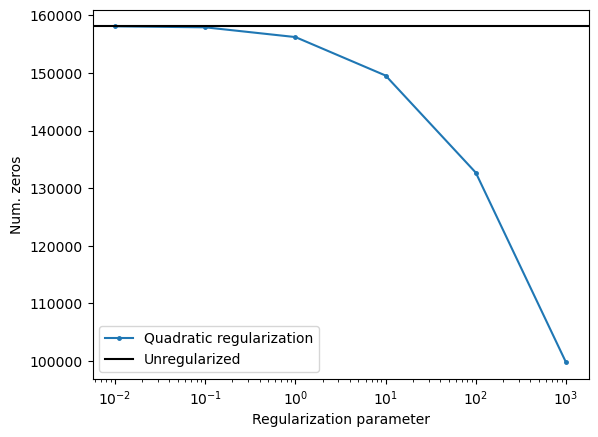

In [31]:
reg = [1e-2, 1e-1, 1., 1e1, 1e2, 1e3]

x0 = drot(np.outer(p, q), Cft, p, q, numba=True,  max_iters=2500, compute_r_primal=True, 
          compute_r_dual=False, eps_abs=1e-5, return_log=False)
n_zeros_unreg = (x0 == 0).sum()

n_zeros_reg = []
for r in reg:
    x = quaddrot(np.outer(p, q), Cft, p, q, r, numba=True,  max_iters=2500, compute_r_primal=True, 
                 compute_r_dual=False, eps_abs=1e-5, return_log=False)
    
    n_zeros_reg.append((x == 0).sum())

plt.semilogx(reg, n_zeros_reg, linestyle='-', marker='.', markersize=5, label='Quadratic regularization')
plt.axhline(n_zeros_unreg, c='k', label='Unregularized')
_ = plt.legend()
_ = plt.xlabel('Regularization parameter')
_ = plt.ylabel('Num. zeros')

# 

Under mild conditions, `drot` and `quaddrot` can identify the correct sparsity pattern in finitely many iterations. When the correct pattern is identified, a faster rate typically dominates. We illustrate this behavious in following cells.

In [48]:
def sparsity_callback(x, phi1, phi2, **kwargs):
    return (x==0).sum()

callbacks = dict(sparsity=sparsity_callback)

reg = 10
x, log = quaddrot(np.outer(p, q), Cft, p, q, reg, numba=True,  max_iters=2500, compute_r_primal=True, 
                 compute_r_dual=False, eps_abs=1e-12, callbacks=callbacks, return_log=True, step=1/n_instances)


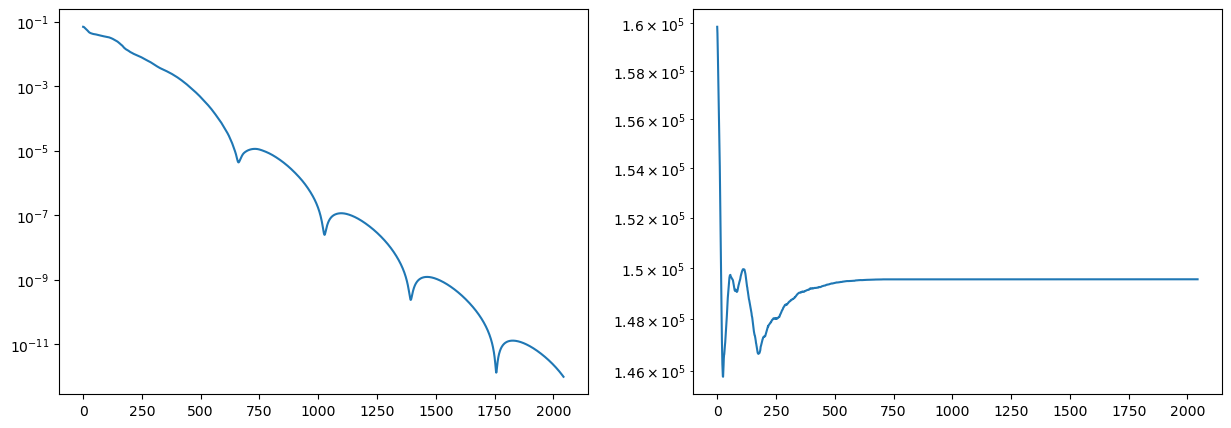

In [49]:
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].semilogy(log['primal'])
ax[1].semilogy(log['sparsity'])